# Lale: Type-Driven Auto-ML with Scikit-Learn

### https://github.com/ibm/lale

### Example Dataset

In [1]:
import lale.datasets.openml
import pandas as pd
(train_X, train_y), (test_X, test_y) = lale.datasets.openml.fetch(
    'credit-g', 'classification', preprocess=False)
pd.concat([pd.DataFrame({'y': train_y}, index=train_X.index).tail(),
           train_X.tail()], axis=1)

,y,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,...,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
835,0,<0,12.0,no credits/all paid,new car,1082.0,<100,1<=X<4,4.0,male single,...,4.0,car,48.0,bank,own,2.0,skilled,1.0,none,yes
192,0,0<=X<200,27.0,existing paid,business,3915.0,<100,1<=X<4,4.0,male single,...,2.0,car,36.0,none,own,1.0,skilled,2.0,yes,yes
629,1,no checking,9.0,existing paid,education,3832.0,no known savings,>=7,1.0,male single,...,4.0,real estate,64.0,none,own,1.0,unskilled resident,1.0,none,yes
559,0,0<=X<200,18.0,critical/other existing credit,furniture/equipment,1928.0,<100,<1,2.0,male single,...,2.0,real estate,31.0,none,own,2.0,unskilled resident,1.0,none,yes
684,1,0<=X<200,36.0,delayed previously,business,9857.0,100<=X<500,4<=X<7,1.0,male single,...,3.0,life insurance,31.0,none,own,2.0,unskilled resident,2.0,yes,yes


### Algorithm Selection and Hyperparameter Tuning

In [2]:
from sklearn.preprocessing import Normalizer as Norm
from sklearn.preprocessing import OneHotEncoder as OneHot
from sklearn.linear_model import LogisticRegression as LR
from xgboost import XGBClassifier as XGBoost
from sklearn.svm import LinearSVC
from lale.operators import make_pipeline, make_union
from lale.lib.lale import Project, ConcatFeatures, NoOp
import lale.helpers
lale.helpers.wrap_imported_operators()

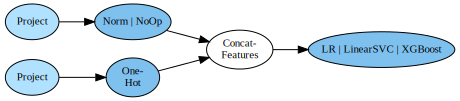

In [3]:
planned_pipeline = make_pipeline(
    make_union(
        make_pipeline(Project(columns={'type': 'number'}), Norm | NoOp),
        make_pipeline(Project(columns={'type': 'string'}), OneHot)),
    (LR | LinearSVC(dual=False)| XGBoost))
lale.helpers.to_graphviz(planned_pipeline)

In [4]:
import sklearn.metrics
from lale.lib.lale import HyperoptClassifier
auto_optimizer = HyperoptClassifier(planned_pipeline, cv=3, max_evals=10)
auto_trained = auto_optimizer.fit(train_X, train_y)
auto_y = auto_trained.predict(test_X)
print(f'accuracy {sklearn.metrics.accuracy_score(test_y, auto_y):.1%}')

100%|██████████| 10/10 [00:32<00:00,  3.17s/it, best loss: -0.7492192504804612]
accuracy 72.1%


### Displaying Automation Results

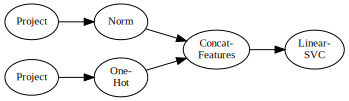

In [5]:
best_pipeline = lale.helpers.best_estimator(auto_trained)
lale.helpers.to_graphviz(best_pipeline)

In [6]:
from lale.pretty_print import ipython_display
ipython_display(best_pipeline, show_imports=False)

```python
project = Project(columns={'type': 'number'})
project_1 = Project_1(columns={'type': 'string'})
linear_svc = LinearSVC(C=29617.427716521834, dual=False, tol=0.0052662071050745525)
pipeline = ((project >> Norm) & (project_1 >> OneHot)) >> ConcatFeatures >> linear_svc
```

### JSON Schemas

https://json-schema.org/

In [7]:
ipython_display(XGBoost.hyperparam_schema('n_estimators'))

```python
{
    'description': 'Number of trees to fit.',
    'type': 'integer',
    'default': 100,
    'minimumForOptimizer': 10,
    'maximumForOptimizer': 1500}
```

In [8]:
ipython_display(XGBoost.hyperparam_schema('booster'))

```python
{
    'description': 'Specify which booster to use.',
    'enum': ['gbtree', 'gblinear', 'dart'],
    'default': 'gbtree'}
```

In [9]:
import jsonschema
import sys
try:
    XGBoost(n_estimators=0.5, booster='gbtree')
except jsonschema.ValidationError as e:
    print(e.message, file=sys.stderr)

Invalid configuration for XGBoost(n_estimators=0.5, booster='gbtree') due to invalid value n_estimators=0.5.
Schema of argument n_estimators: {
    'description': 'Number of trees to fit.',
    'type': 'integer',
    'default': 100,
    'minimumForOptimizer': 10,
    'maximumForOptimizer': 1500}
Value: 0.5


### Customizing Schemas

In [10]:
import lale.schemas as schemas
Grove = XGBoost.customize_schema(
    n_estimators=schemas.Int(min=2, max=10),
    booster=schemas.Enum(['gbtree']))

In [11]:
grove_planned = ( Project(columns={'type': 'number'}) >> Norm
                & Project(columns={'type': 'string'}) >> OneHot
                ) >> ConcatFeatures >> Grove

In [12]:
grove_optimizer = HyperoptClassifier(grove_planned, cv=3, max_evals=25)
grove_trained = grove_optimizer.fit(train_X, train_y)
grove_y = grove_trained.predict(test_X)
print(f'accuracy {sklearn.metrics.accuracy_score(test_y, grove_y):.1%}')

100%|██████████| 25/25 [01:10<00:00,  2.69s/it, best loss: -0.7432802156737135]
accuracy 73.6%


In [13]:
grove_best = lale.helpers.best_estimator(grove_trained)
ipython_display(grove_best, show_imports=False)

```python
project = Project(columns={'type': 'number'})
norm = Norm(norm='max')
project_1 = Project_1(columns={'type': 'string'})
xgboost = XGBoost(booster='gbtree', colsample_bylevel=0.817076341278144, colsample_bytree=0.9684171195424505, learning_rate=0.8124216867510974, max_depth=6, min_child_weight=15, n_estimators=2, reg_alpha=0.6694979805849552, reg_lambda=0.23029025992909025, subsample=0.7515971229195682)
pipeline = ((project >> norm) & (project_1 >> OneHot)) >> ConcatFeatures >> xgboost
```

### Human-in-the-Loop Auto-ML

### https://github.com/ibm/lale

<img src="img/2019-1208-loops.png" style="width:700px" align="left">